In [2]:
import cv2
import mediapipe as mp
import os
import csv
import time

# MediaPipe 초기화
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    max_num_faces=1,
    refine_landmarks=True,  # Keep as True to use all refined landmarks
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5)

# 얼굴 특징점 그리기 도구 설정
mp_drawing = mp.solutions.drawing_utils
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

# 클래스 목록 및 초기 설정
classes = ["normal", "head_tilting", "slow_eye_closure", "yawning"]
current_class = None
measuring = False

# 데이터 저장 변수
data = []

# 데이터셋 디렉토리 생성
dataset_dir = os.path.join(os.getcwd(), "111")
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)
for cls in classes:
    class_dir = os.path.join(dataset_dir, cls)
    if not os.path.exists(class_dir):
        os.makedirs(class_dir)

# 웹캠 열기
cap = cv2.VideoCapture(0)

print("클래스를 선택하세요:")
print("'q' - normal")
print("'w' - head_tilting")
print("'e' - slow_eye_closure")
print("'r' - yawning")
print("'m' - 5초 동안 측정 시작")
print("'Esc' - 프로그램 종료")

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        print("웹캠에서 프레임을 가져올 수 없습니다.")
        break

    # 프레임을 RGB로 변환
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # 얼굴 특징점 추출
    results = face_mesh.process(frame_rgb)

    # 얼굴 특징점 시각화
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            # 특징점 그리기
            mp_drawing.draw_landmarks(
                image=frame,
                landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_TESSELATION,
                landmark_drawing_spec=drawing_spec,
                connection_drawing_spec=drawing_spec)
            # 측정 중이면 데이터 저장
            if measuring and current_class is not None:
                timestamp = time.time()
                landmarks = []
                for lm in face_landmarks.landmark:
                    landmarks.extend([lm.x, lm.y, lm.z])
                data.append([timestamp] + landmarks)

                # 현재 프레임의 랜드마크 수 출력
                print(f"Number of landmarks: {len(face_landmarks.landmark)}")

    # 현재 클래스 및 측정 상태 표시
    info_text = f"Class: {current_class if current_class else 'None'} | Measuring: {'On' if measuring else 'Off'}"
    cv2.putText(frame, info_text, (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)

    # 결과 출력
    cv2.imshow('MediaPipe Face Mesh', frame)

    # 키보드 입력 처리
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        current_class = 'normal'
        print("현재 클래스: normal")
    elif key == ord('w'):
        current_class = 'head_tilting'
        print("현재 클래스: head_tilting")
    elif key == ord('e'):
        current_class = 'slow_eye_closure'
        print("현재 클래스: slow_eye_closure")
    elif key == ord('r'):
        current_class = 'yawning'
        print("현재 클래스: yawning")
    elif key == ord('m'):
        if current_class is None:
            print("클래스를 먼저 선택하세요.")
        else:
            print("5초 동안 측정 시작")
            measuring = True
            data = []
            start_time = time.time()
            capture_interval = 1 / 30  # 30 FPS에 해당하는 간격
            last_capture_time = start_time

            while time.time() - start_time < 5:
                current_time = time.time()
                if current_time - last_capture_time >= capture_interval:
                    success, frame = cap.read()
                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    results = face_mesh.process(frame_rgb)

                    if results.multi_face_landmarks:
                        for face_landmarks in results.multi_face_landmarks:
                            timestamp = time.time()
                            landmarks = [timestamp]
                            for lm in face_landmarks.landmark:
                                landmarks.extend([lm.x, lm.y, lm.z])
                            data.append(landmarks)

                            # 랜드마크 개수 출력
                            print(f"Number of landmarks: {len(face_landmarks.landmark)}")

                    # 얼굴 특징점 그리기
                    for face_landmarks in results.multi_face_landmarks:
                        mp_drawing.draw_landmarks(
                            image=frame,
                            landmark_list=face_landmarks,
                            connections=mp_face_mesh.FACEMESH_TESSELATION,
                            landmark_drawing_spec=drawing_spec,
                            connection_drawing_spec=drawing_spec)

                    cv2.putText(frame, f"Class: {current_class} | Measuring: On (5 sec)",
                                (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)
                    cv2.imshow('MediaPipe Face Mesh', frame)

                    # 타이밍 갱신
                    last_capture_time = current_time

                if cv2.waitKey(1) & 0xFF == 27:  # 'Esc' key로 중간에 종료 가능
                    break

            # 측정 종료 후 데이터 저장
            measuring = False
            if data:
                class_index = classes.index(current_class)
                filename = f"{class_index}_{int(time.time())}.csv"
                class_dir = os.path.join(dataset_dir, current_class)
                filepath = os.path.join(class_dir, filename)
                # 데이터 저장 시 랜드마크 개수를 첫 행에 추가
                header = ["timestamp"] + [f"lm_{i}_{axis}" for i in range(len(face_landmarks.landmark)) for axis in ("x", "y", "z")]
                with open(filepath, 'w', newline='') as csvfile:
                    writer = csv.writer(csvfile)
                    writer.writerow(header)
                    writer.writerows(data)
                print(f"데이터가 {filepath}에 저장되었습니다.")
            else:
                print("저장할 데이터가 없습니다.")
    elif key == 27:  # 'Esc' 키
        print("프로그램을 종료합니다.")
        break

# 자원 해제
cap.release()
cv2.destroyAllWindows()

I0000 00:00:1732015467.101351 7909174 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M1 Pro
W0000 00:00:1732015467.104064 7912644 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1732015467.110071 7912646 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


클래스를 선택하세요:
'q' - normal
'w' - head_tilting
'e' - slow_eye_closure
'r' - yawning
'm' - 5초 동안 측정 시작
'Esc' - 프로그램 종료
현재 클래스: normal
현재 클래스: head_tilting
현재 클래스: slow_eye_closure
현재 클래스: yawning
현재 클래스: normal
현재 클래스: head_tilting
현재 클래스: slow_eye_closure
현재 클래스: head_tilting
현재 클래스: normal
현재 클래스: head_tilting
현재 클래스: slow_eye_closure
현재 클래스: yawning
현재 클래스: normal
현재 클래스: head_tilting
현재 클래스: head_tilting
현재 클래스: normal
현재 클래스: head_tilting
현재 클래스: slow_eye_closure
현재 클래스: yawning
현재 클래스: normal
현재 클래스: slow_eye_closure
현재 클래스: yawning
현재 클래스: head_tilting
5초 동안 측정 시작
Number of landmarks: 478
Number of landmarks: 478
Number of landmarks: 478
Number of landmarks: 478
Number of landmarks: 478
Number of landmarks: 478
Number of landmarks: 478
Number of landmarks: 478
Number of landmarks: 478
Number of landmarks: 478
Number of landmarks: 478
Number of landmarks: 478
Number of landmarks: 478
Number of landmarks: 478
Number of landmarks: 478
Number of landmarks: 478
Number of landmarks: 478
N

Processed 0/98 frames
Processed 10/98 frames
Processed 20/98 frames
Processed 30/98 frames
Processed 40/98 frames
Processed 50/98 frames
Processed 60/98 frames
Processed 70/98 frames
Processed 80/98 frames
Processed 90/98 frames
GIF가 './face_mesh_animation.gif'에 저장되었습니다.


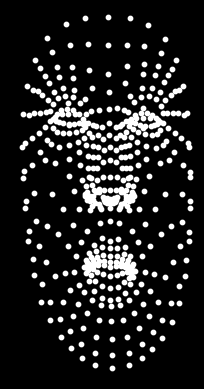

In [4]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import imageio

# 스타일을 dark_background로 설정
plt.style.use('dark_background')

csv_file = './111/normal/0_1731857709.csv'
gif_file = './face_mesh_animation.gif'

# CSV 파일 읽기 및 좌표 데이터 추출
frames = []
x_values = []
y_values = []
with open(csv_file, newline='') as csvfile:
    reader = csv.reader(csvfile)
    header = next(reader)  # 헤더 스킵
    for row in reader:
        # 각 행에서 x, y 좌표 추출 (z는 무시)
        coordinates = np.array(row[1:], dtype=np.float32).reshape(-1, 3)
        frames.append(coordinates[:, :2])  # x, y 좌표만 저장
        x_values.extend(coordinates[:, 0])
        y_values.extend(coordinates[:, 1])

# x와 y 좌표의 최소 및 최대값을 사용해 축 범위를 설정
x_min, x_max = min(x_values), max(x_values)
y_min, y_max = min(y_values), max(y_values)

# GIF 저장을 위한 설정
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_facecolor('black')
ax.axis('off')  # 축 제거

# 얼굴 특징점을 표시할 흰색 점 및 선
images = []
for frame in frames:
    ax.clear()
    ax.set_aspect('equal')
    ax.set_facecolor('black')
    ax.axis('off')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_max, y_min)  # y 축을 반전

    # 얼굴 특징점 좌표를 흰색 점으로 표시
    ax.scatter(frame[:, 0], frame[:, 1], c='white', s=10)

    # 플롯을 이미지로 변환
    fig.canvas.draw()
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(image)

# GIF 저장 (프레임당 100ms로 설정)
imageio.mimsave(gif_file, images, duration=30)

# print(f"GIF가 {gif_file}로 저장되었습니다.")